In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(0)

In [3]:
def g(x, a):
    """
    TBSS kernel applicable to the rBergomi variance process.
    """
    return x**a

def b(k, a):
    """
    Optimal discretisation of TBSS process for minimising hybrid scheme error.
    """
    return ((k**(a+1)-(k-1)**(a+1))/(a+1))**(1/a)

def cov(a, n):
    """
    Covariance matrix for given alpha and n, assuming kappa = 1 for
    tractability.
    """
    cov = np.array([[0.,0.],[0.,0.]])
    cov[0,0] = 1./n
    cov[0,1] = 1./((1.*a+1) * n**(1.*a+1))
    cov[1,1] = 1./((2.*a+1) * n**(2.*a+1))
    cov[1,0] = cov[0,1]
    return cov

In [4]:
class rBergomi(object):
    """
    Class for generating paths of the rBergomi model.
    """
    def __init__(self, n = 100, N = 1000, T = 1.00, a = -0.4):
        """
        Constructor for class.
        """
        # Basic assignments
        self.T = T # Maturity
        self.n = n # Granularity (steps per year)
        self.dt = 1.0/self.n # Step size
        self.s = int(self.n * self.T) # Steps
        self.t = np.linspace(0, self.T, 1 + self.s)[np.newaxis,:] # Time grid
        self.a = a # Alpha
        self.N = N # Paths

        # Construct hybrid scheme correlation structure for kappa = 1
        self.e = np.array([0,0])
        self.c = cov(self.a, self.n)

    def dW1(self):
        """
        Produces random numbers for variance process with required
        covariance structure.
        """
        rng = np.random.multivariate_normal
        return rng(self.e, self.c, (self.N, self.s))

    def Y(self, dW):
        """
        Constructs Volterra process from appropriately
        correlated 2d Brownian increments.
        """
        Y1 = np.zeros((self.N, 1 + self.s)) # Exact integrals
        Y2 = np.zeros((self.N, 1 + self.s)) # Riemann sums

        # Construct Y1 through exact integral
        for i in np.arange(1, 1 + self.s):
            Y1[:,i] = dW[:,i-1,1] # Assumes kappa = 1

        # Construct arrays for convolution
        G = np.zeros(1 + self.s) # Gamma
        for k in np.arange(2, 1 + self.s, 1):
            G[k] = g(b(k, self.a)/self.n, self.a)
        
        X = dW[:,:,0] # Xi

        # Initialise convolution result, GX
        GX = np.zeros((self.N, len(X[0,:]) + len(G) - 1))

        # Compute convolution
        for i in range(self.N):
            GX[i,:] = np.convolve(G, X[i,:])
        
        # Extract appropriate part of convolution
        Y2 = GX[:,:1 + self.s]

        # Finally contruct and return full process
        Y = np.sqrt(2 * self.a + 1) * (Y1 + Y2)
        return Y

In [5]:
N = 2; T = 1;
H = 0.1; alpha = H - 0.5;
rB = rBergomi(n = 1000, N = N, T = T, a = alpha)

In [6]:
Y = rB.Y(rB.dW1())

<IPython.core.display.Javascript object>


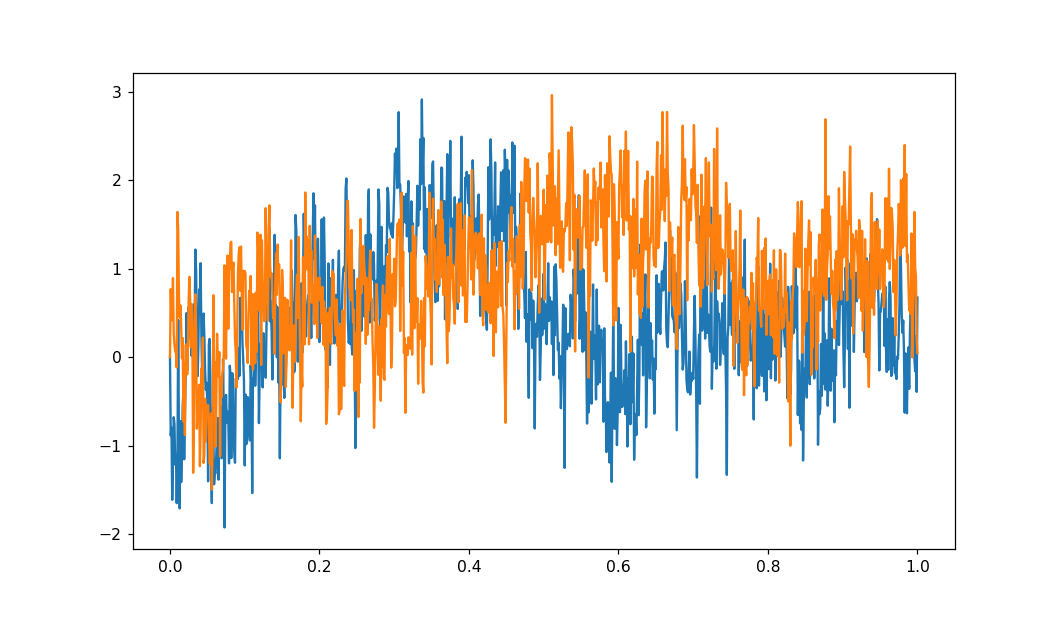

In [7]:
%matplotlib notebook

for i in range(N):
    plt.plot(rB.t[0], Y[i])